In [1]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle
import pathlib

import datetime
import scipy.fftpack as fftp
import os

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import re
today = arange('2019-01-26T20:11', '2019-01-27T08:46', dtype='datetime64[m]')
times=datetime_as_string(today, casting='no')
folder_name = "../STMDATA/2019-01-26/"
output=empty((0,3))
for el in times[:60]:
    data = load(folder_name+"trxn"+re.sub(r"\D", "", el)+".npy")
    output = concatenate((output,data))

Text(0, 0.5, 'Z Coordinate (m)')

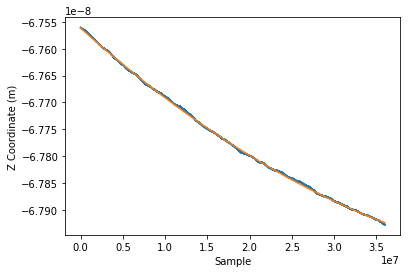

In [3]:
t = linspace(0,shape(output)[0],shape(output)[0])
fit = polyfit(t,output[:,2],2)
fit
plot(t[::1000],output[::1000,2])
plot(t[::1000],fit[0]*(t[::1000]**2)+t[::1000]*fit[1]+fit[2])
xlabel('Sample')
ylabel('Z Coordinate (m)')

In [4]:
scan_freq=10000
z_offset=output[:,2]-(fit[0]*(t**2)+t*fit[1]+fit[2])
nc = cancel.Cancel(output[:,1],z_offset,(1/scan_freq),p=[50000,10000,5])

(30, 300)

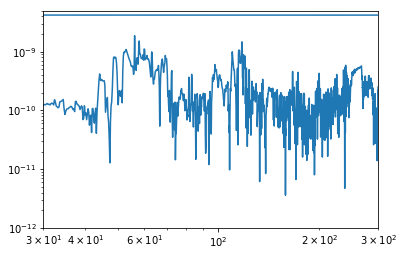

In [7]:
loglog(nc.freqs, abs(nc.transf(nc.freqs)))
ylim(10e-13,5e-9)
xlim(30,300)

In [5]:
for count in range(11):
    print(count)
    output=empty((0,3))
    for el in times[60+count*60:120+count*60]:
        output = concatenate((output,load(folder_name+"trxn"+re.sub(r"\D", "", el)+".npy")))
    t = linspace(0,shape(output)[0],shape(output)[0])
    fit = polyfit(t,output[:,2],2)
    z_offset=output[:,2]-(fit[0]*(t**2)+t*fit[1]+fit[2])
    nc.update_transf(output[:,1],z_offset,(1/scan_freq),p=[50000,10000,5])

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
loglog(nc.freqs,  abs(nc.transf(nc.freqs)))
xlim(1,300)

In [10]:
pathlib.Path(folder_name).mkdir(parents=True, exist_ok=True) 
with open(folder_name+'transfer-fxn2.pkl', 'wb') as output:
    pickle.dump(nc, output)

MemoryError: 

In [10]:
from sklearn.externals import joblib
filename = folder_name+'transfer-fxn2.pkl'
joblib.dump(nc, filename)  

['../STMDATA/2019-01-26/transfer-fxn2.pkl']

In [2]:
with open('../STMDATA/2019-01-28/transfer-fxn.pkl', 'rb') as input:
    nc = pickle.load(input)

C:\Users\Albert Chien\AppData\Roaming\Python\Python36\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


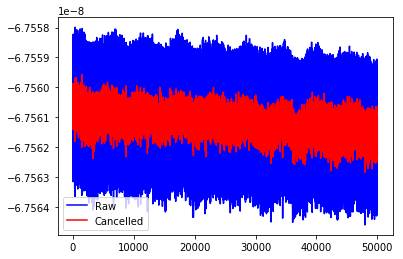

In [12]:
cur=output[:50000,0]
geo=output[:50000,1]
z=output[:50000,2]
plot(z, 'b', label='Raw')
plot(z - nc.create_drive(geo), 'r', label='Cancelled')
legend()

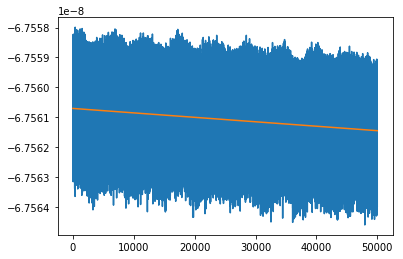

In [11]:
t = linspace(0,50000,50000)
fit = polyfit(t,z,1)
fit
plot(t,z)
plot(t,fit[0]*t+fit[1])
# plot(log(output[::1000,2]))

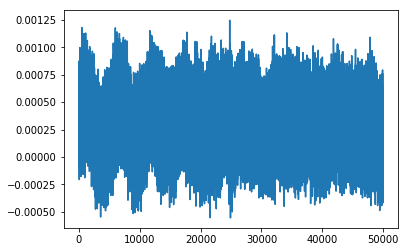

In [28]:
plot(geo)

In [11]:
# b = -1.64825832e+10      -5e+10
b = -1.64825832e+10
log_a = -2.39285218e+01
cur_noise = exp(-(nc.create_drive(geo))*b)

a = 10000

plot(cur[:a], 'b', label='Raw')
plot((cur/cur_noise*mean(cur_noise))[:a], 'y', label='Cancelled', alpha=0.7)
legend()

NameError: name 'geo' is not defined

In [15]:
test = loadtxt("../STMDATA/2019-01-28/2019-01-28-12-43-scan-data025.dat", skiprows=137)
test = concatenate((test, loadtxt("../STMDATA/2019-01-28/2019-01-28-12-43-scan-data026.dat", skiprows=137)))

In [13]:
# b = -1.64825832e+10      -5e+10
b = -1.64825832e+10
log_a = -2.39285218e+01
cur_noise = exp(-(nc.create_drive(test[:,1]))*b)

a = 10000

plot(test[:a,0], 'b', label='Raw')
# plot((test[:,0]/cur_noise*mean(cur_noise))[:a], 'y', label='Raw Cancelled', alpha=0.7)
plot((test[:,0]*cur_noise/mean(cur_noise))[:a], 'y', label='Raw Cancelled', alpha=0.7)
legend()

TypeError: 'PytestTester' object is not subscriptable

In [2]:
import re
today = arange('2019-01-28T14:58', '2019-01-28T21:26', dtype='datetime64[m]')
times=datetime_as_string(today, casting='no')
folder_name = "../STMDATA/2019-01-28/"
output=empty((0,3))
for el in times[:60]:
    data = load(folder_name+"trxn"+re.sub(r"\D", "", el)+".npy")
    output = concatenate((output,data))

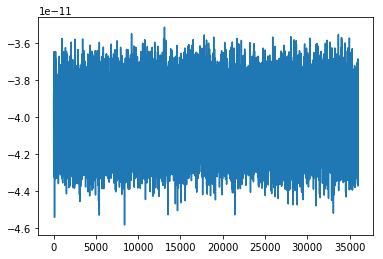

In [3]:
plot(output[::1000,0])

(1, 1000)

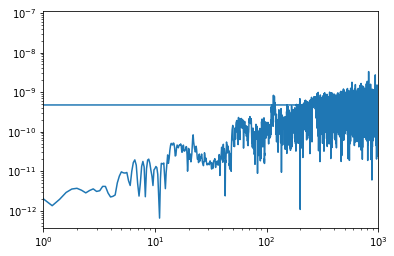

In [3]:
scan_freq=10000
geo=output[:,1]
cur_offset=output[:,0]-mean(output[:,0])
nc = cancel.Cancel(geo-mean(geo),cur_offset,(1/scan_freq),p=[50000,10000,16])
loglog(nc.freqs,  abs(nc.transf(nc.freqs)))
xlim(1,1000)

In [4]:
import pickle
import pathlib
pathlib.Path(folder_name).mkdir(parents=True, exist_ok=True) 
with open(folder_name+'transfer-fxn-cur2.pkl', 'wb') as output:
    pickle.dump(nc, output, pickle.HIGHEST_PROTOCOL)

In [14]:
def cancel_skips(array, tol):
    data = array[15:]-array[:-15]
    markers = where(abs(data)>=tol)*sign(data)[where(abs(data)>=tol)]
    result = array[0:abs(int(markers[0][0]))]
    counter=markers[0][0]
    gap = 0
    for idx in markers[0]:
        if (counter*idx) < 1:
#             print(abs(counter),abs(int(idx)), gap)
            result = concatenate((result,array[abs(int(counter)):abs(int(idx))]-gap))
            counter = idx
            gap = 0
        else:
            if markers[0][0] > 0: gap = max(gap,data[abs(int(idx))])
            else: gap = min(gap,data[abs(int(idx))])
    if shape(array) is not shape(result):
#         print("last")
        result = concatenate((result,array[abs(int(counter)):]-gap))
    return result

plot(cancel_skips(output[:,2], 3e-12)[::1000])

KeyboardInterrupt: 

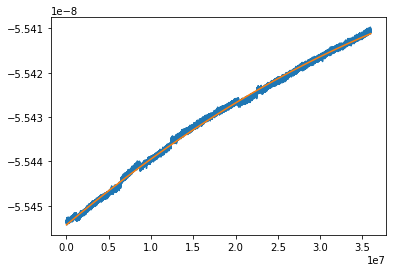

In [6]:
z=cancel_skips(output[:,2], 3e-12)
geo=output[:,1]

t = linspace(0,size(z),size(z))
fit = polyfit(t,z,2)
plot(t[::1000],z[::1000])
plot(t[::1000],fit[0]*t[::1000]**2+t[::1000]*fit[1]+fit[2])

(1, 1000)

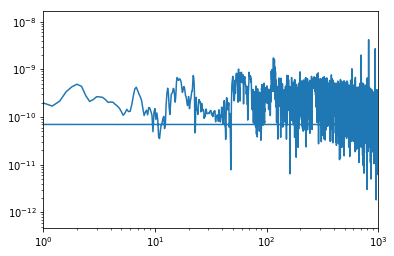

In [7]:
scan_freq=10000
z_offset=z-(fit[0]*(t**2)+t*fit[1]+fit[2])
nc = cancel.Cancel(geo,z_offset,(1/scan_freq),p=[50000,10000,16])
loglog(nc.freqs,  abs(nc.transf(nc.freqs)))
xlim(1,1000)

In [8]:
import pickle
import pathlib
pathlib.Path(folder_name).mkdir(parents=True, exist_ok=True) 
with open(folder_name+'transfer-fxn.pkl', 'wb') as output:
    pickle.dump(nc, output, pickle.HIGHEST_PROTOCOL)

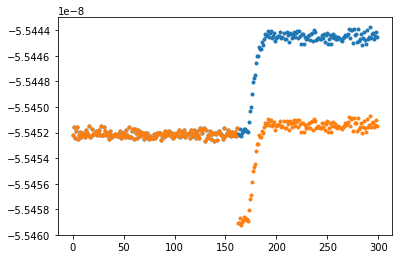

In [62]:
# plot(output[1000000:2000000,2])
plot(output[1671800:1672100,2],'.')
plot(result[1671800:1672100],'.')

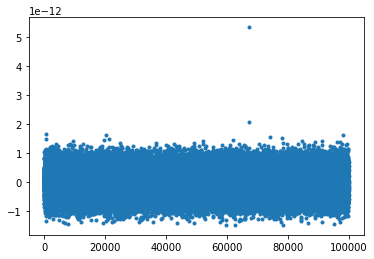

In [26]:
plot(diff(output[1000000:2000000:10,2]),'.')

In [2]:
import re
today = arange('2019-01-29T09:24', '2019-01-29T09:44', dtype='datetime64[m]')
times=datetime_as_string(today, casting='no')
folder_name = "../STMDATA/2019-01-29/"
output=empty((0,6))
for el in times[:60]:
    data = load(folder_name+"bias-spec"+re.sub(r"\D", "", el)+".npy")
    output = concatenate((output,data))

In [3]:
from sklearn.externals import joblib

[transf, freqs] = joblib.load('../STMDATA/2019-01-26/transfer-fxn3')
# loglog(nc.freqs,  abs(nc.transf(nc.freqs)))
# xlim(1,1000)

In [4]:
def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver

In [5]:
out_cur = output[:,0]
out_geo = output[:,1]
out_v = output[:,2]
out_z = output[:,3]
out_lix = output[:,4]
out_liy = output[:,5]

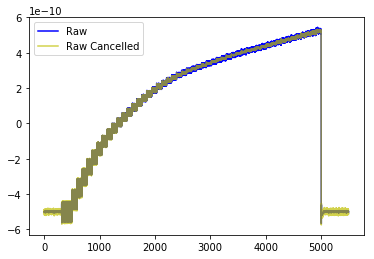

In [22]:
# b = -1.64825832e+10      -5e+10
start = 49000
end = 54500
b = -1.64825832e+10
log_a = -2.39285218e+01
cur_noise = exp(-(create_drive(out_geo-mean(out_geo), 1/10000, transf, freqs))[start:end]*b)
cur = out_cur[start:end]

plot(cur, 'b', label='Raw')
plot((cur/cur_noise*mean(cur_noise)), 'y', label='Raw Cancelled', alpha=0.7)
legend()

C:\Users\Albert Chien\AppData\Roaming\Python\Python36\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


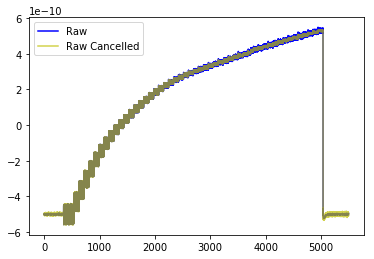

In [6]:
# b = -1.64825832e+10      -5e+10
start = 20000
end = 25500
b = -1.64825832e+10
log_a = -2.39285218e+01
cur_noise = exp(-(create_drive(out_geo-mean(out_geo), 1/10000, transf, freqs))[start:end]*b)
cur = out_cur[start:end]

plot(cur, 'b', label='Raw')
plot((cur/cur_noise*mean(cur_noise)), 'y', label='Raw Cancelled', alpha=0.7)
legend()

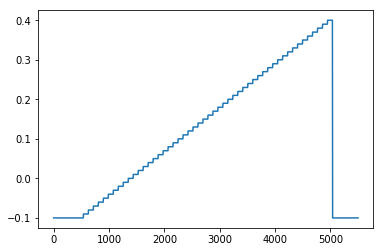

In [7]:
plot(out_v[start:end])

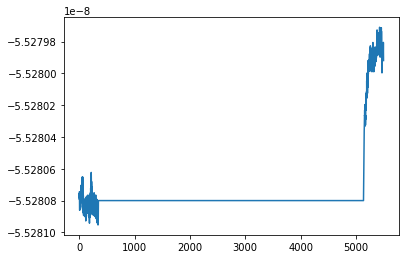

In [14]:
plot(out_z[start:end])

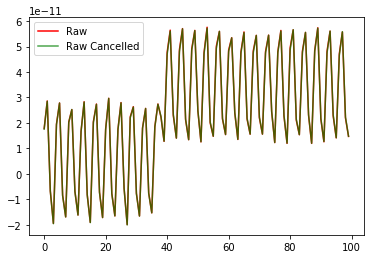

In [11]:
a = 1400
b = 1500
plot(cur[a:b], 'r', label='Raw')
plot((cur/cur_noise*mean(cur_noise))[a:b], 'g', label='Raw Cancelled', alpha=0.7)
legend()

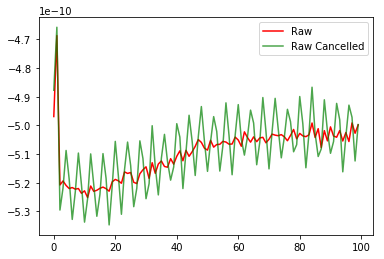

In [16]:
a = 5040
b = 5140
plot(cur[a:b], 'r', label='Raw')
plot((cur/cur_noise*mean(cur_noise))[a:b], 'g', label='Raw Cancelled', alpha=0.7)
legend()

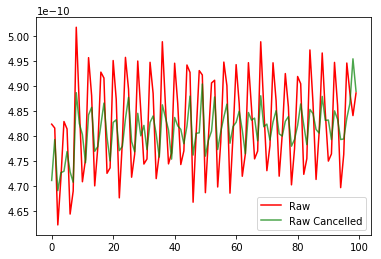

In [12]:
a = 4400
b = 4500
plot(cur[a:b], 'r', label='Raw')
plot((cur/cur_noise*mean(cur_noise))[a:b], 'g', label='Raw Cancelled', alpha=0.7)
legend()

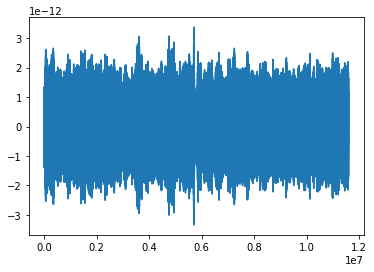

In [13]:
plot(create_drive(output[:,1]-mean(output[:,1]), 1/10000, transf, freqs))

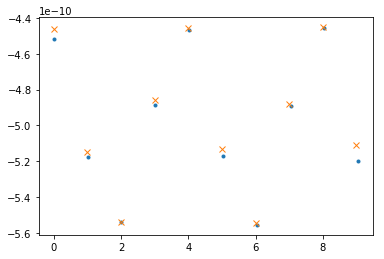

In [19]:
from scipy.optimize import leastsq

a = 357
b = 538
# plot(cur[a:b],'x')
data = cur[a:b]
t = linspace(0, b-a, b-a)

guess_amp = 2.0e-10
# guess_freq = 10/1.25
guess_freq = 2*pi/4
guess_phase = 0
guess_mean = -5.0e-10

optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]


# recreate the fitted curve using the optimized parameters
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

# recreate the fitted curve using the optimized parameters

fine_t = np.arange(0,max(t),1)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean

plt.plot(t[:10], data[:10], '.')
plt.plot(fine_t[:10], data_fit[:10], 'x')

In [62]:
est_freq

1.5621141603031172

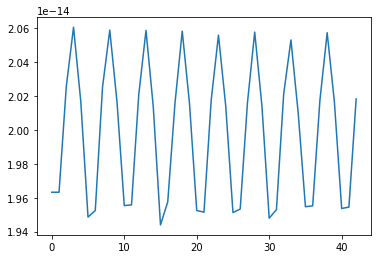

In [20]:
offset=-96.7544*pi/180
out_ref = out_v[start+a:start+b]+10.0e-3*sin(2*pi/5*fine_t+est_phase+offset)
test_liy_raw = out_ref * cur[a:b]
test_liy = sum(test_liy_raw[:172].reshape(-1, 4), axis=1)/10000
plot(test_liy)

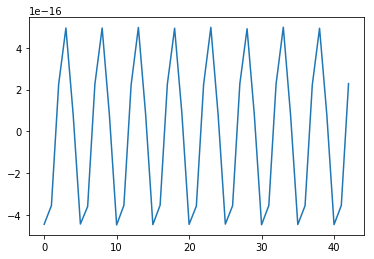

In [67]:
offset=-96.7544*pi/180
out_ref = 10.0e-3*sin(2*pi/5*fine_t+est_phase+offset)
cur_offset = cur[:172].reshape(-1, 4) - mean(cur[:172].reshape(-1, 4))
test_liy = sum(out_ref[:172].reshape(-1, 4)*cur_offset, axis=1)/10000
plot(test_liy)

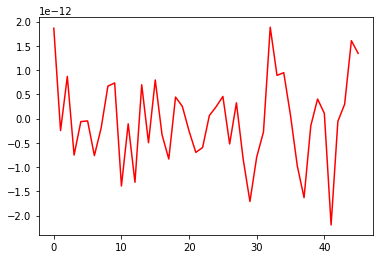

In [34]:
plot(out_lix[a:b:4],'r')

In [60]:
t_long = arange(0,max(t)+1000,1)
offset=-96.7544*pi/180
out_ref = 10.0e-3*sin(2*pi/5*t_long+est_phase+offset)
cur_offset = cur[:172+1000].reshape(-1, 4) - mean(cur[:172+1000].reshape(-1, 4), axis=1)
test_liy = sum(out_ref[:172+1000].reshape(-1, 4)*cur_offset, axis=1)/10000
plot(test_liy)

ValueError: operands could not be broadcast together with shapes (293,4) (293,) 

In [66]:
shape(repeat(mean(cur[:172+1000].reshape(-1, 4), axis=1),4,))

(1172,)

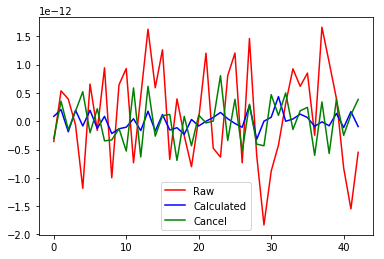

In [18]:
guess_amp = 19.9e-3
guess_freq = 2*pi/5
guess_phase = -96.7544*pi/180

optimize_func = lambda x: sum((x[0]*sin(x[1]*fine_t+x[2]))[:172].reshape(-1, 4)*cur_offset, axis=1)/10000 - out_liy[a:a+43*4:4]
est_amp, est_freq, est_phase = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase])[0]

cur_offset_cancel = (cur/cur_noise*mean(cur_noise))[:172].reshape(-1, 4) - mean((cur/cur_noise*mean(cur_noise))[:172].reshape(-1, 4))

data_fit=sum((est_amp*sin(est_freq*fine_t+est_phase))[:172].reshape(-1, 4)*cur_offset, axis=1)/10000
data_cancel=sum((est_amp*sin(est_freq*fine_t+est_phase))[:172].reshape(-1, 4)*cur_offset_cancel, axis=1)/10000
theoretical=sum((10.0e-3*sin(2*pi/5*fine_t+est_phase+offset))[:172].reshape(-1, 4)*cur_offset_cancel, axis=1)/10000

plot(out_liy[a:a+43*4:4],'r', label='Raw')
plot(data_fit,'b', label='Calculated')
plot(data_cancel,'g',label='Cancel')
legend()

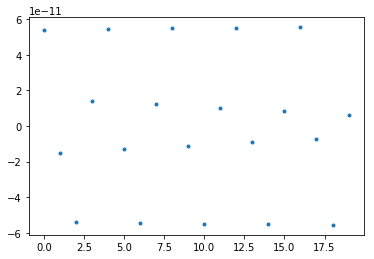

In [26]:
plot(est_amp*sin(est_freq*fine_t+est_phase)[:20],'.')

In [28]:
pi/2

1.5707963267948966